### xG is the probability of a shot to be a goal given the position of the player and angle of the shot.
    I have build a base model using XG-Boost to predict the probability of a shot will be a Goal.

#### Data: Statsbomb
 Scrapped over 1000 matches in both genders(male and female) and proccessd the data to predict the probability of a   shot is a goal.

#### Evaluation Metric:
 This is an example of class imbalance data. 
 We can either use precision or recall or both (F-Score)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats


import statsmodels.formula.api as smf

import random
random.seed=10000
# from sklearn.metrics import f1
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Data
df = pd.read_parquet('final/shots.parquet')

In [3]:
df.shape

(24803, 38)

In [4]:
pd.set_option('display.max_columns',None)
df.columns = map(str.lower, df.columns)

In [5]:
df.columns

Index(['match_id', 'id', 'eventsec', 'period', 'goal', 'team_id', 'team_name',
       'player_id', 'firstname', 'middlename', 'lastname', 'name',
       'shot_type_name', 'x', 'y', 'counter_attack', 'fast_break',
       'strong_foot', 'body_part_name', 'assist_type', 'pass_end_y',
       'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
       'pass_height_name', 'pass_technique_name', 'carry_length',
       'visible_angle', 'middle_angle', 'distance_to_goal',
       'distance_visible_angle', 'log_distance_to_goal', 'competition_gender',
       'shot_one_on_one', 'shot_open_goal', 'under_pressure',
       'player_id_goalkeeper'],
      dtype='object')

In [6]:
#Dropping unnecessary features
df=df.drop(columns=['match_id', 'id',  'team_id', 'team_name',
       'player_id', 'firstname', 'middlename', 'lastname', 'name',
       'shot_type_name', 'player_id_goalkeeper', 'distance_to_goal'], axis=1)


In [7]:
df.head()

,eventsec,period,goal,x,y,counter_attack,fast_break,strong_foot,body_part_name,assist_type,pass_end_y,pass_end_x,pass_switch,pass_cross,pass_cut_back,pass_height_name,pass_technique_name,carry_length,visible_angle,middle_angle,distance_visible_angle,log_distance_to_goal,competition_gender,shot_one_on_one,shot_open_goal,under_pressure
0,39.290,1,False,102.1,-36.2,False,False,True,Right Foot,pass,-29.9,99.1,False,False,False,Ground/ Low Pass,None,6.498106,0.049353,0.621117,5.951992,4.792479,female,False,False,True
1,344.364,1,False,90.8,-43.6,False,False,True,Right Foot,direct,NaN,NaN,None,None,None,None,None,NaN,0.046882,0.729495,5.457117,4.757033,female,False,False,False
2,610.693,1,False,99.5,-22.4,False,False,True,Right Foot,pass,-16.7,97.8,False,False,False,Ground/ Low Pass,None,5.518464,0.056829,0.533461,6.302364,4.708629,female,False,False,False
3,802.844,1,True,106.8,-36.1,False,True,True,Left Foot,pass,-44.5,95.4,False,False,False,High Pass,Through Ball,13.406287,0.048609,0.598479,6.046937,4.823502,female,True,False,False
4,1192.551,1,False,102.1,-46.8,False,False,True,Right Foot,recovery,NaN,NaN,None,None,None,None,None,NaN,0.044465,0.688996,5.651537,4.844974,female,False,False,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24803 entries, 0 to 24802
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eventsec                24803 non-null  float64
 1   period                  24803 non-null  int64  
 2   goal                    24803 non-null  bool   
 3   x                       24803 non-null  float64
 4   y                       24803 non-null  float64
 5   counter_attack          24803 non-null  bool   
 6   fast_break              24803 non-null  bool   
 7   strong_foot             24803 non-null  bool   
 8   body_part_name          24803 non-null  object 
 9   assist_type             24803 non-null  object 
 10  pass_end_y              17628 non-null  float64
 11  pass_end_x              17628 non-null  float64
 12  pass_switch             17628 non-null  object 
 13  pass_cross              17628 non-null  object 
 14  pass_cut_back           17628 non-null

In [9]:
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

for col in bool_cols:
    df[col] = df[col].astype(int)
    df[col] = df[col].astype('object')

In [10]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
pass_technique_name,22122,89.190824
pass_cross,7175,28.927952
pass_height_name,7175,28.927952
carry_length,7175,28.927952
pass_end_y,7175,28.927952
pass_end_x,7175,28.927952
pass_switch,7175,28.927952
pass_cut_back,7175,28.927952
shot_open_goal,0,0.000000
shot_one_on_one,0,0.000000


In [11]:
# Drop NA and fill na values

df.pass_end_x.fillna(df.x, inplace=True)
df.pass_end_y.fillna(df.y, inplace=True)
df.pass_technique_name.fillna('nn', inplace=True)
df.carry_length.fillna(0, inplace=True)
df.pass_height_name.fillna('nn', inplace=True)



df=df.drop(columns=['pass_cross','pass_cut_back','pass_switch'],axis=1)


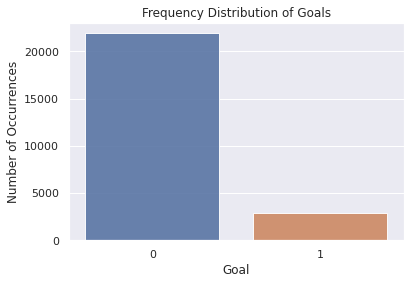

0    21910
1     2893
Name: goal, dtype: int64


0    0.883361
1    0.116639
Name: goal, dtype: float64

In [12]:
class_count1 = df['goal'].value_counts()
sns.set(style="darkgrid")
sns.barplot(class_count1.index, class_count1.values, alpha=0.9)
plt.title('Frequency Distribution of Goals')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Goal', fontsize=12)
plt.show()
print(df['goal'].value_counts())
df.goal.value_counts(normalize=True)

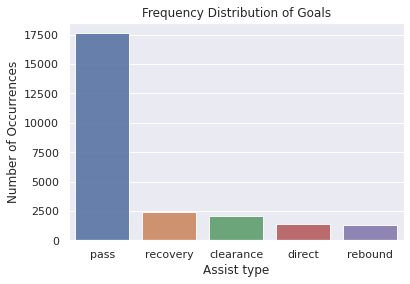

pass         17628
recovery      2450
clearance     2029
direct        1362
rebound       1334
Name: assist_type, dtype: int64


pass         0.710720
recovery     0.098778
clearance    0.081805
direct       0.054913
rebound      0.053784
Name: assist_type, dtype: float64

In [13]:
class_count1 = df['assist_type'].value_counts()
sns.set(style="darkgrid")
sns.barplot(class_count1.index, class_count1.values, alpha=0.9)
plt.title('Frequency Distribution of Goals')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Assist type', fontsize=12)
plt.show()
print(df['assist_type'].value_counts())
df.assist_type.value_counts(normalize=True)

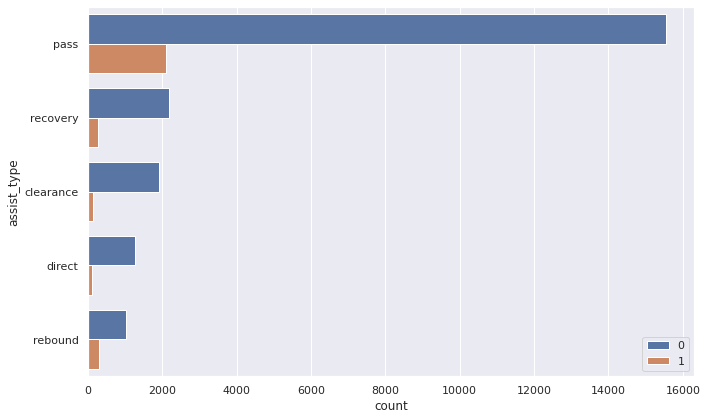

In [14]:
plt.figure(figsize=(10,6))
ax=sns.countplot(y='assist_type',order=['pass','recovery','clearance','direct','rebound'],hue='goal',data=df);
plt.legend(loc='lower right');
plt.tight_layout()
plt.savefig('assist_type.png')

In [15]:
df.body_part_name.value_counts()

Right Foot    13151
Left Foot      8002
Other          3650
Name: body_part_name, dtype: int64

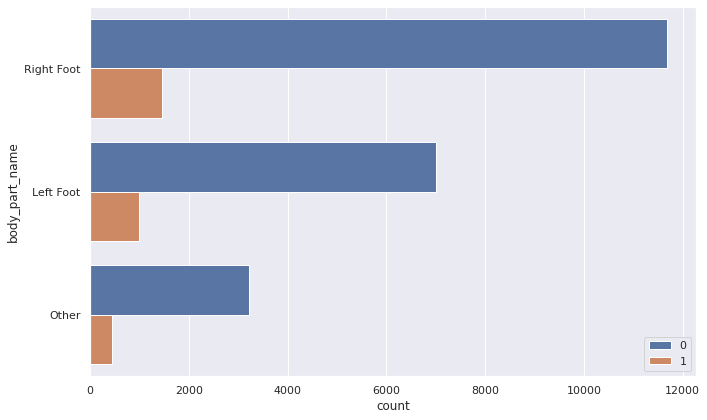

In [16]:
plt.figure(figsize=(10,6))
ax=sns.countplot(y='body_part_name',order=['Right Foot','Left Foot','Other'],hue='goal',data=df);
plt.legend(loc='lower right');
plt.tight_layout()
plt.savefig('body_part_name.png')

In [17]:
df.groupby(['goal']).mean()

,eventsec,period,x,y,pass_end_y,pass_end_x,carry_length,visible_angle,middle_angle,distance_visible_angle,log_distance_to_goal
goal,,,,,,,,,,,
0,1458.511626,1.544546,103.147691,-35.669192,-35.602725,100.641251,4.464048,0.049448,0.611748,5.972894,4.797606
1,1462.077889,1.547874,108.895541,-36.085413,-36.289112,106.503387,3.821348,0.048252,0.588795,6.077542,4.837640


In [18]:
df.groupby(['assist_type','goal']).mean()

eventsec    period           x          y  pass_end_y  \
assist_type goal                                                             
clearance   0     1456.992083  1.539190  100.591846 -36.378958  -36.378958   
            1     1455.846984  1.507812  107.314063 -37.842188  -37.842188   
direct      0     1554.687648  1.568127   93.919363 -35.243187  -35.243187   
            1     1591.636636  1.476636   95.543925 -37.292523  -37.292523   
pass        0     1456.006513  1.543517  104.380456 -35.561697  -35.467948   
            1     1451.016278  1.546323  109.267049 -35.953725  -36.235148   
rebound     0     1467.980013  1.563230  107.160798 -36.132490  -36.132490   
            1     1475.417007  1.601307  112.797386 -36.009804  -36.009804   
recovery    0     1418.077620  1.534215  100.029516 -35.842062  -35.842062   
            1     1485.395767  1.546512  107.574419 -35.871705  -35.871705   

                  pass_end_x  carry_length  visible_angle  middle_angle  \
assist_type goal                                                          
clearance   0     100.591846      0.000000       0.049528      0.628784   
            1     107.314063      0.000000       0.047767      0.607121   
direct      0      93.919363      0.000000       0.051292      0.652012   
            1      95.543925      0.000000       0.049959      0.657436   
pass        0     100.845236      6.296336       0.049296      0.605036   
            1     105.962130      5.279446       0.048259      0.585977   
rebound     0     107.160798      0.000000       0.048489      0.597296   
            1     112.797386      0.000000       0.047550      0.572600   
recovery    0     100.029516      0.000000       0.049848      0.628265   
            1     107.574419      0.000000       0.048563      0.593322   

                  distance_visible_angle  log_distance_to_goal  
assist_type goal                                                
clearance   0                   5.902465              4.783825  
            1                   6.002487              4.835353  
direct      0                   5.792398              4.733001  
            1                   5.770746              4.755257  
pass        0                   6.002398              4.805448  
            1                   6.090132              4.839546  
rebound     0                   6.037866              4.826523  
            1                   6.146621              4.862487  
recovery    0                   5.897751              4.777409  
            1                   6.057904              4.828004

### Split X and Y

In [24]:
X = df.drop('goal', axis=1)
y = df.goal
y= y.astype(int)

In [25]:
X= pd.get_dummies(X, columns=['counter_attack',
 'fast_break',
 'strong_foot',
 'shot_one_on_one',
 'shot_open_goal',
 'under_pressure',
'body_part_name','assist_type','pass_height_name','pass_technique_name',
  'competition_gender'], drop_first=False)

X.head()

,eventsec,period,x,y,pass_end_y,pass_end_x,carry_length,visible_angle,middle_angle,distance_visible_angle,log_distance_to_goal,counter_attack_0,counter_attack_1,fast_break_0,fast_break_1,strong_foot_0,strong_foot_1,shot_one_on_one_0,shot_one_on_one_1,shot_open_goal_0,shot_open_goal_1,under_pressure_0,under_pressure_1,body_part_name_Left Foot,body_part_name_Other,body_part_name_Right Foot,assist_type_clearance,assist_type_direct,assist_type_pass,assist_type_rebound,assist_type_recovery,pass_height_name_Ground/ Low Pass,pass_height_name_High Pass,pass_height_name_nn,pass_technique_name_Inswinging,pass_technique_name_Outswinging,pass_technique_name_Straight,pass_technique_name_Through Ball,pass_technique_name_nn,competition_gender_female,competition_gender_male
0,39.290,1,102.1,-36.2,-29.9,99.1,6.498106,0.049353,0.621117,5.951992,4.792479,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0
1,344.364,1,90.8,-43.6,-43.6,90.8,0.000000,0.046882,0.729495,5.457117,4.757033,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0
2,610.693,1,99.5,-22.4,-16.7,97.8,5.518464,0.056829,0.533461,6.302364,4.708629,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0
3,802.844,1,106.8,-36.1,-44.5,95.4,13.406287,0.048609,0.598479,6.046937,4.823502,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,1192.551,1,102.1,-46.8,-46.8,102.1,0.000000,0.044465,0.688996,5.651537,4.844974,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0


### Train and Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12345, stratify=y)

In [27]:


print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))



Shots train 19842 ;Number goals 2314 ;Goals %:  11.7
Shots test 4961 ;Number goals 579 ;Goals %:  11.7


## Modeling:

In [33]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV

from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOTClassifier

#### 1. Logistic Regression

In [30]:

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

pred_logreg = logreg.predict(X_test)

In [32]:
acc_score_logreg = accuracy_score(y_test, pred_logreg)
print('Testing accuracy: ',acc_score_logreg)

recall_logreg=recall_score(y_test, pred_logreg,pos_label=1)
print('Testing Recall: ',recall_logreg)

precision_logreg=precision_score(y_test, pred_logreg,pos_label=1)
print('Testing precision: ',precision_logreg)

f1_logreg= f1_score(y_test, pred_logreg,pos_label=1)
print('Testing F1-Score: ',f1_logreg)

roc_auc_logreg = roc_auc_score(y_test,pred_logreg)
print('ROC AUC score: ',roc_auc_logreg)

conf_mat_logreg = confusion_matrix(y_test, pred_logreg)
print('Confusion Matrix: \n',conf_mat_logreg)

class_rep3_logreg = classification_report(y_test,pred_logreg)
print('Classification Report: \n',class_rep3_logreg)

Testing accuracy:  0.8875226768796614
Testing Recall:  0.06217616580310881
Testing precision:  0.7058823529411765
Testing F1-Score:  0.11428571428571428
ROC AUC score:  0.5293765356628506
Confusion Matrix: 
 [[4367   15]
 [ 543   36]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      4382
           1       0.71      0.06      0.11       579

    accuracy                           0.89      4961
   macro avg       0.80      0.53      0.53      4961
weighted avg       0.87      0.89      0.84      4961



In [34]:
params = {
    'n_neighbors': range(1,20)
}

ga_knn = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.neighbors.KNeighborsClassifier': params}, 
                                 cv = 3, scoring = 'roc_auc')
ga_knn=ga_knn.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.64554286749991

Generation 2 - Current best internal CV score: 0.64554286749991

Generation 3 - Current best internal CV score: 0.64554286749991

Generation 4 - Current best internal CV score: 0.6455892293753362

Generation 5 - Current best internal CV score: 0.6456749664381246

Best pipeline: KNeighborsClassifier(CombineDFs(input_matrix, KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), n_neighbors=6)), n_neighbors=19)


In [35]:
best_knn=KNeighborsClassifier(n_neighbors=19)
best_knn.fit(X_train, y_train)
pred_knn = best_knn.predict(X_test)

In [36]:
#Checking different metrics for KNN model after tuning the hyperparameters
print('Checking different metrics for KNN model after tuning the hyperparameters:\n')


acc_score_knn = accuracy_score(y_test, pred_knn)
print('Testing accuracy: ',acc_score_knn)

recall_knn=recall_score(y_test, pred_knn,pos_label=1)
print('Testing Recall: ',recall_knn)

precision_knn=precision_score(y_test, pred_knn,pos_label=1)
print('Testing precision: ',precision_knn)

f1_knn= f1_score(y_test, pred_knn,pos_label=1)
print('Testing F1-Score: ',f1_knn)

conf_mat_knn = confusion_matrix(y_test, pred_knn)
print('Confusion Matrix: \n',conf_mat_knn)

roc_auc_knn = roc_auc_score(y_test,pred_knn)
print('ROC AUC score: ',roc_auc_knn)

class_rep3_knn = classification_report(y_test,pred_knn)
print('Classification Report: \n',class_rep3_knn)

Checking different metrics for KNN model after tuning the hyperparameters:

Testing accuracy:  0.8826849425519049
Testing Recall:  0.0034542314335060447
Testing precision:  0.2857142857142857
Testing F1-Score:  0.006825938566552901
Confusion Matrix: 
 [[4377    5]
 [ 577    2]]
ROC AUC score:  0.5011565999705184
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      4382
           1       0.29      0.00      0.01       579

    accuracy                           0.88      4961
   macro avg       0.58      0.50      0.47      4961
weighted avg       0.81      0.88      0.83      4961



###  Random Forest

In [37]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['gini']}

# Set the hyperparameters of GA 
ga_rf = TPOTClassifier(generations= 3, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 3, scoring = 'roc_auc')
ga_rf=ga_rf.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7692655773705624

Generation 2 - Current best internal CV score: 0.770121363048362

Generation 3 - Current best internal CV score: 0.7702192795535218

Best pipeline: RandomForestClassifier(input_matrix, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300)


In [38]:
best_rf=RandomForestClassifier(criterion='gini', max_depth=10, max_features='auto', min_samples_leaf=4, min_samples_split=2, n_estimators=300)

best_rf.fit(X_train, y_train)
pred_rf = best_rf.predict(X_test)

In [39]:
#Checking different metrics for random forest model after tuning the hyperparameters
print('Checking different metrics for random forest model after tuning the hyperparameters:\n')


acc_score_rf = accuracy_score(y_test, pred_rf)
print('Testing accuracy: ',acc_score_rf)

recall_rf=recall_score(y_test, pred_rf,pos_label=1)
print('Testing Recall: ',recall_rf)

precision_rf=precision_score(y_test, pred_rf,pos_label=1)
print('Testing precision: ',precision_rf)

f1_rf= f1_score(y_test, pred_rf,pos_label=1)
print('Testing F1-Score: ',f1_rf)

conf_mat_rf = confusion_matrix(y_test, pred_rf)
print('Confusion Matrix: \n',conf_mat_rf)

roc_auc_rf = roc_auc_score(y_test,pred_rf)
print('ROC AUC score: ',roc_auc_rf)

class_rep3_rf = classification_report(y_test,pred_rf)
print('Classification Report: \n',class_rep3_rf)

Checking different metrics for random forest model after tuning the hyperparameters:

Testing accuracy:  0.8901431163071961
Testing Recall:  0.07426597582037997
Testing precision:  0.8269230769230769
Testing F1-Score:  0.13629160063391443
Confusion Matrix: 
 [[4373    9]
 [ 536   43]]
ROC AUC score:  0.5361060595669678
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      4382
           1       0.83      0.07      0.14       579

    accuracy                           0.89      4961
   macro avg       0.86      0.54      0.54      4961
weighted avg       0.88      0.89      0.85      4961



### XG-Boost

In [40]:

paramgrid = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (1, 10),
        'max_depth': (1, 50),
        'min_child_weight': (1, 5),
        'n_estimators': (50, 100),
    'eval_metric':['logloss']
    }

ga_xgb = TPOTClassifier(generations= 8, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'xgboost.XGBClassifier': paramgrid}, 
                                 cv = 4, scoring = 'roc_auc')
ga_xgb=ga_xgb.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7687610337863291

Generation 2 - Current best internal CV score: 0.7687610337863291

Generation 3 - Current best internal CV score: 0.7687610337863291

Generation 4 - Current best internal CV score: 0.7687610337863291

Generation 5 - Current best internal CV score: 0.7687610337863291

Generation 6 - Current best internal CV score: 0.7687610337863291

Generation 7 - Current best internal CV score: 0.7687610337863291

Generation 8 - Current best internal CV score: 0.7687610337863291

Best pipeline: XGBClassifier(input_matrix, eval_metric=logloss, learning_rate=1.0, max_depth=1, min_child_weight=5, n_estimators=50)


In [45]:
best_xgb=XGBClassifier(eval_metric='logloss',learning_rate=1, max_depth=1, min_child_weight=5, n_estimators=50)
best_xgb.fit(X_train, y_train)
pred_xgb = best_xgb.predict(X_test)

In [44]:
#Checking different metrics for random forest model after tuning the hyperparameters
print('Checking different metrics for random forest model after tuning the hyperparameters:\n')


acc_score_xgb = accuracy_score(y_test, pred_xgb)
print('Testing accuracy: ',acc_score_xgb)

recall_xgb=recall_score(y_test, pred_xgb,pos_label=1)
print('Testing Recall: ',recall_xgb)

precision_xgb=precision_score(y_test, pred_xgb,pos_label=1)
print('Testing precision: ',precision_xgb)

f1_xgb= f1_score(y_test, pred_xgb,pos_label=1)
print('Testing F1-Score: ',f1_xgb)

conf_mat_xgb = confusion_matrix(y_test, pred_xgb)
print('Confusion Matrix: \n',conf_mat_xgb)

roc_auc_xgb = roc_auc_score(y_test,pred_xgb)
print('ROC AUC score: ',roc_auc_xgb)

class_rep3_xgb = classification_report(y_test,pred_xgb)
print('Classification Report: \n',class_rep3_xgb)

Checking different metrics for random forest model after tuning the hyperparameters:

Testing accuracy:  0.8903446885708527
Testing Recall:  0.10535405872193437
Testing precision:  0.7011494252873564
Testing F1-Score:  0.1831831831831832
Confusion Matrix: 
 [[4356   26]
 [ 518   61]]
ROC AUC score:  0.5497103474805474
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      4382
           1       0.70      0.11      0.18       579

    accuracy                           0.89      4961
   macro avg       0.80      0.55      0.56      4961
weighted avg       0.87      0.89      0.85      4961



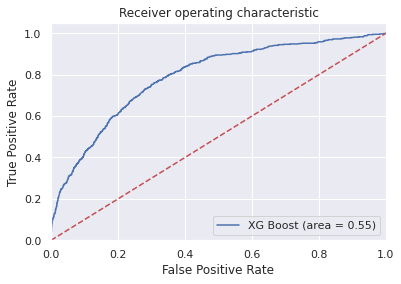

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, best_xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XG Boost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Feature Importance

In [48]:
# !pip install shap

     |████████████████████████████████| 564 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 7.6 MB/s  eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


In [55]:
import shap
import numpy as np
import matplotlib.pylab as pl
import xgboost

<AxesSubplot:>

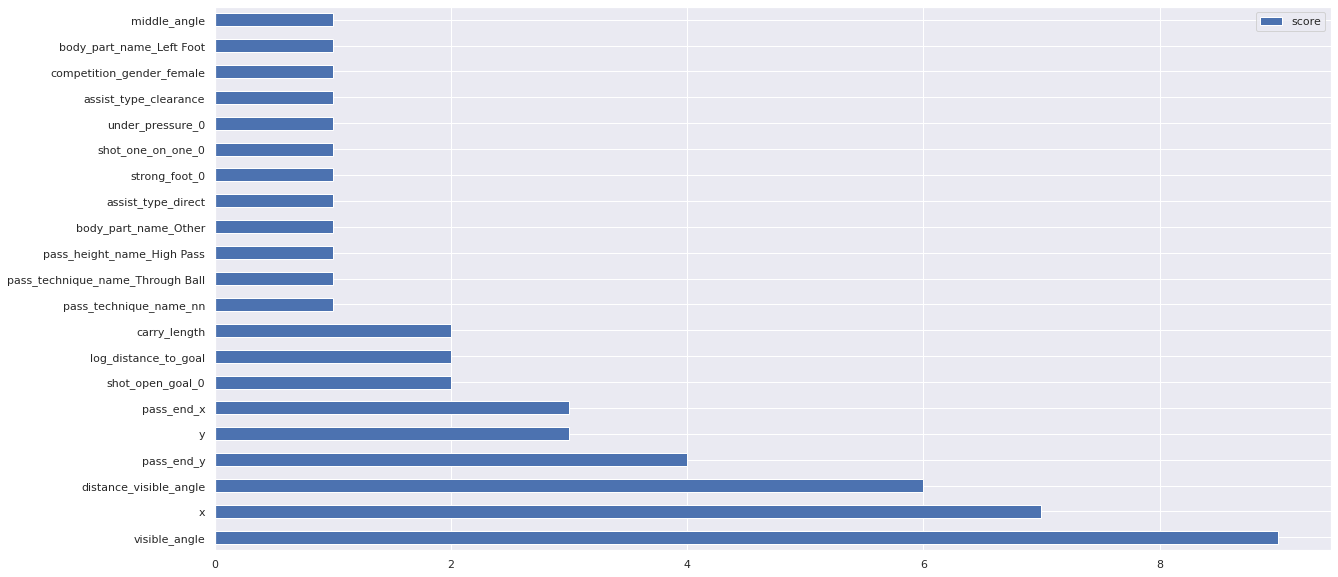

In [61]:
feature_important = best_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [63]:
import joblib
#save model
joblib.dump(best_xgb, 'best_model') 
best_xgb.save_model('xgb.model')

#### Results and Next steps:

1. I haven't attached the data pre-processing files.
2. XG-boost has the best F-Score (~19%), so it performed better than other models we experimented.
3. This is the base model. The model can be improved by adding more data and advanced models like
   Neural Networks can be built to get better results.
4. Feature selection can be done to reduce the processing time.
5. References: Friends of Tracking, Stackoverflow, Medium, mlpsoccer, statsbomb.
6. Building a data product which takes imput from the user and gives X-pected goals.